# How to win in Jeopardy?

Jeopardy! is an American television game show. The show features a quiz competition in which contestants are presented with general knowledge clues in the form of answers, and must phrase their responses in the form of questions. For example, if a contestant were to select "Presidents for $200", the resulting clue could be "This 'Father of Our Country' didn't really chop down a cherry tree", to which the correct response is "Who is/was George Washington?"

In this analysis we will try to figure out whether one should study past questions, study general knowledge, or not study it all to increase the chances to perform better on the show.

Data set contains over 200000 rows(10% of all the questions that ever appeared on the show) of information in csv format.

In [71]:
#reading in data
import pandas as pd
jeopardy = pd.read_csv('jeopardy.csv')
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [72]:
jeopardy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216930 entries, 0 to 216929
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Show Number  216930 non-null  int64 
 1    Air Date    216930 non-null  object
 2    Round       216930 non-null  object
 3    Category    216930 non-null  object
 4    Value       216930 non-null  object
 5    Question    216930 non-null  object
 6    Answer      216928 non-null  object
dtypes: int64(1), object(6)
memory usage: 11.6+ MB


Here we have 216930 rows and 7 columns. 

6 out of 7 column names has leading space which has to be removed. 

Some of the columns has wrong data types. In the next steps we will change 'Air date' dtype to datetime for easier sorting by date, and 'Value' has to be changed to float data type to be able to perform numerical operations.

# 1. Cleaning data

In [73]:
#delete leading spaces in the column names
jeopardy_columns = jeopardy.copy()
for i, name in enumerate(jeopardy_columns.columns): 
    jeopardy_columns.columns.values[i] = name.lstrip()
        
jeopardy_columns.columns

Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')

In [74]:
#change dtype in 'Air Date' column
jeopardy_date = jeopardy_columns.copy()
jeopardy_date.iloc[:,1] = pd.to_datetime(jeopardy_date.iloc[:,1])
jeopardy_date.dtypes

Show Number             int64
Air Date       datetime64[ns]
Round                  object
Category               object
Value                  object
Question               object
Answer                 object
dtype: object

In [75]:
#Check value column to see what values we might find
jeopardy_columns.iloc[:,4].value_counts()[:20]

$400      42244
$800      31860
$200      30455
$600      20377
$1000     19539
$1200     11331
$2000     11243
$1600     10801
$100       9029
$500       9016
$300       8663
None       3634
$1,000     2101
$2,000     1586
$3,000      769
$1,500      546
$1,200      441
$4,000      349
$1,600      239
$2,500      232
Name: Value, dtype: int64

In order to convert 'Value' column data type to float, dollar sign has to be removed, as well as commas.
There is also 3634 'None' values. Lets look further into these rows.

In [76]:
jeopardy_columns[jeopardy_columns.iloc[:,4]=='None'][:10]

,Show Number,Air Date,Round,Category,Value,Question,Answer
55,4680,2004-12-31,Final Jeopardy!,THE SOLAR SYSTEM,None,Objects that pass closer to the sun than Mercu...,Icarus
116,5957,2010-07-06,Final Jeopardy!,HISTORIC WOMEN,None,She was born in Virginia around 1596 & died in...,Pocahontas
174,3751,2000-12-18,Final Jeopardy!,SPORTS LEGENDS,None,If Joe DiMaggio's hitting streak had gone one ...,H.J. Heinz (Heinz 57 Varieties)
235,3673,2000-07-19,Final Jeopardy!,THE MAP OF EUROPE,None,"Bordering Italy, Austria, Hungary & Croatia, i...",Slovenia
296,4931,2006-02-06,Final Jeopardy!,FAMOUS SHIPS,None,"On December 27, 1831 it departed Plymouth, Eng...",the HMS Beagle
357,5690,2009-05-08,Final Jeopardy!,EUROPEAN HISTORY,None,"He filed for divorce citing Leviticus 20:21, ""...",Henry VIII
418,2825,1996-12-06,Final Jeopardy!,BRITISH NOVELS,None,"This 1895 novel is subtitled ""An Invention""",The Time Machine
474,6037,2010-12-07,Final Jeopardy!,FLAGS OF THE WORLD,None,"In use from 1844 to 1905, a flag representing ...",Norway and Sweden
535,5243,2007-05-30,Final Jeopardy!,THE BRITISH THEATRE,None,"Richard Attenborough, who was in the original ...",The Mousetrap
594,3036,1997-11-10,Final Jeopardy!,THE CONSTITUTION,None,"Word completing the line ""Nor shall any person...",Jeopardy


These 'None' values appear in Final Jeopardy! or Tiebraker rounds. During these rounds players can pick their wager freely so no winning amount is set. Even though these questions are considered as difficult, or high value, we can not set any amount to their value because it might bias the results of the analysis. Instead they will be replaced with 'nan' values. 

In [77]:
#remove dollar sign in 'Value' column and convert to numeric. 3634 rows has 'None' value.
jeopardy_value = jeopardy_date.copy()
jeopardy_value.iloc[:,4] = jeopardy_value.iloc[:,4].apply(lambda x: x.replace('$','')).apply(lambda x: x.replace(',',''))
jeopardy_value.iloc[:,4] = pd.to_numeric(jeopardy_value.iloc[:,4], errors = 'coerce') #3643 rows has 'nan' value
jeopardy_value.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,200.0,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200.0,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200.0,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200.0,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200.0,"Signer of the Dec. of Indep., framer of the Co...",John Adams


The data types are correct now, lets move on to question and answer columns. To work with these values, they have to be cleaned, letters changed to lowercase and all punctuation removed.

In [78]:
#normalize 'Question' and 'Answer' columns, remove punctuation and convert to lowercase
jeopardy_normalize = jeopardy_value.copy()

import re
jeopardy_normalize['clean_question'] = jeopardy_normalize.iloc[:,5].apply(lambda x: x.lower()).apply(lambda x: re.sub(r'\W', ' ', x))
jeopardy_normalize['clean_answer'] = jeopardy_normalize.iloc[:,6].apply(lambda x: str(x).lower()).apply(lambda x: re.sub(r'\W', ' ', x))

jeopardy_normalize.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer
0,4680,2004-12-31,Jeopardy!,HISTORY,200.0,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was ...,copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200.0,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisl...,jim thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200.0,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200.0,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,in 1963 live on the art linkletter show th...,mcdonald s
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200.0,"Signer of the Dec. of Indep., framer of the Co...",John Adams,signer of the dec of indep framer of the co...,john adams


# 2. Analysis

Purpose of this analysis is to get insights into what might increase our chances to win the game.

Try to answer these questions:

-How often answers are found in the questions? 

-Are there any relationship patterns between Round and Category values?

-Is it worth studying most common terms used in the questions?

In [79]:
#create a function to find if Question and Answer has matching words
jeopardy_match = jeopardy_normalize.copy()

def match(row): #'row' - full row from dataframe 
    split_answer = row['clean_answer'].split()
    split_question = row['clean_question'].split()
    
    match_count = 0
    if 'the' in split_answer:
        split_answer = split_answer.remove('the') #remove 'the' because it has no real value to the results
    if split_answer is None or len(split_answer) == 0: return 0 #if split_answer is empty list, set result to 0 to avoid error in division by 0 later
    else: 
        for word in split_answer:
            if word in split_question: match_count += 1
    return match_count/len(split_answer)

jeopardy_match['answer_in_question'] = jeopardy_match.apply(lambda x: match(x), axis=1)
jeopardy_match['answer_in_question'].mean()

0.04935285413188554

An answer stated in question appears to be in almost 5% of the questions.

Lets move on to another question - Are there any relationship patterns between Round and Category values?

In [80]:
#see the Round column values and their fequencies
jeopardy_match['Round'].value_counts()

Jeopardy!           107384
Double Jeopardy!    105912
Final Jeopardy!       3631
Tiebreaker               3
Name: Round, dtype: int64

Majority of questions falls into Jeopardy! and Double Jeopardy! rounds.
Lets see Category column.

In [178]:
#top 10 question categories
print('Total categories: ',len(jeopardy_match['Category'].unique()))
jeopardy_match['Category'].value_counts()[:10]

Total categories:  27995


BEFORE & AFTER             547
SCIENCE                    519
LITERATURE                 496
AMERICAN HISTORY           418
POTPOURRI                  401
WORLD HISTORY              377
WORD ORIGINS               371
COLLEGES & UNIVERSITIES    351
HISTORY                    349
SPORTS                     342
Name: Category, dtype: int64

In [179]:
#group by 'Round' and see if there is any obvious patterns in Category column
jeopardy_group_round = jeopardy_match[['Round','Category']].groupby(by='Round')['Category'].value_counts()
dbl_jeo = jeopardy_group_round.loc['Double Jeopardy!'][:10]
jeo = jeopardy_group_round.loc['Jeopardy!'][:10]
final_jeo = jeopardy_group_round.loc['Final Jeopardy!'][:10]

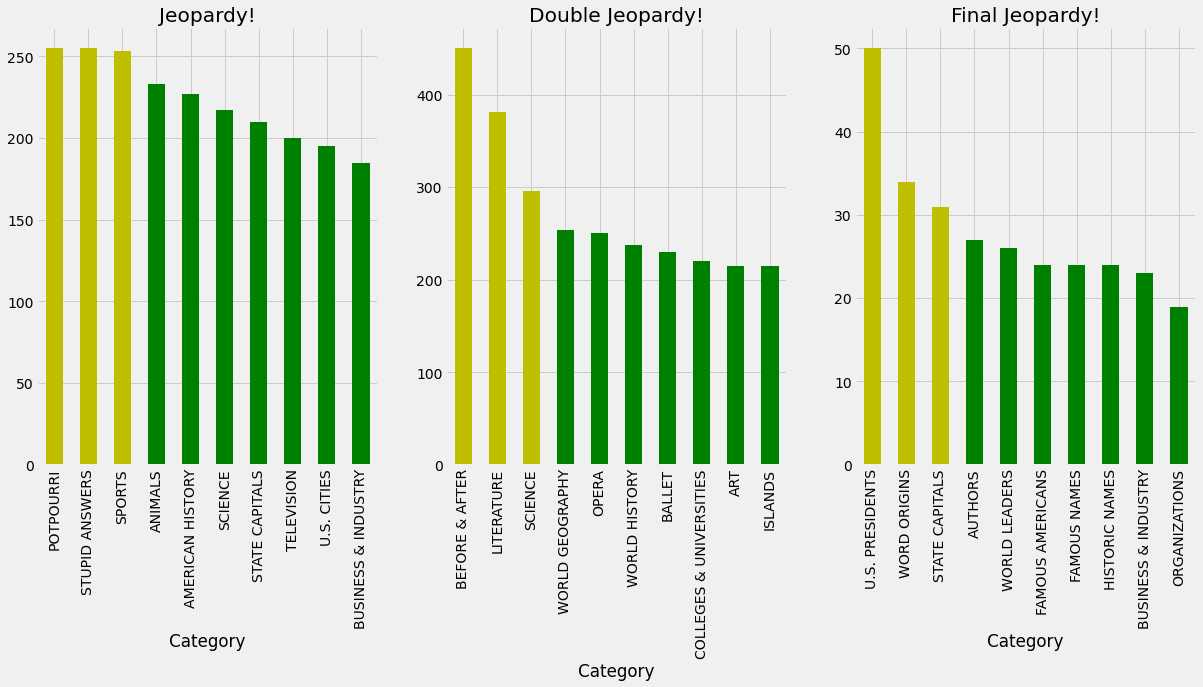

In [176]:
#plot the results
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(1,3)
fig.set_size_inches(18.5, 7.5)
colors = ['y','y','y','g','g','g','g','g','g','g']
jeo.plot(kind='bar', title='Jeopardy!', ax=axes[0], color = colors)
dbl_jeo.plot(kind='bar', title='Double Jeopardy!', ax=axes[1], color = colors)
final_jeo.plot(kind='bar', title='Final Jeopardy!', ax=axes[2], color = colors)

plt.show()

Every round has three categories that appear most often. Having knowledge in these categories could increase chances to win the game.

Are there any particular terms that are related with high-value questions? Are these terms occur in high-value questions by chance or there is some pattern? Answering these questions could help to figure out whether it is worth to study subjects related with most common terms that occurs in high-value questions in order to increase the chances to win the game.

Pearson's chi-square test might help to figure out whether the terms fall into high-value or low-value by chance or there is a statistical significance. 

To perform chi-square test it is neccessary to define hypotheses and p-value threshold.

Hypothesis(null) - all terms in all questions appear equaly likely.

Hypothesis(alternative) - reject null hypothesis(terms in high- and low-value questions appear not equaly likely)

P-value threshold - 5%

In [181]:
#make a new column containing terms found in 'Questions' that are longer than 6 characters
def terms(question):
    split = question.split()
    return [word for word in split if len(word)>6]
    
jeopardy_match['terms_used'] = jeopardy_match['clean_question'].apply(lambda x: terms(x))
jeopardy_match['terms_used'].head()

0                       [galileo, espousing]
1    [olympian, football, carlisle, seasons]
2                        [average, sunshine]
3           [linkletter, company, billionth]
4                  [constitution, president]
Name: terms_used, dtype: object

In [85]:
#create a list of all terms
terms_used_list = []
def terms_to_list(term):
    return [terms_used_list.append(word) for word in term]
jeopardy_match['terms_used'].apply(lambda x: terms_to_list(x))
terms_used_list[:5]

['galileo', 'espousing', 'olympian', 'football', 'carlisle']

In [86]:
#count occurancies of terms
terms_count = pd.Series(terms_used_list).value_counts()

#these are the top 10 terms used in questions
terms_count[:10]

archive      12979
country       6045
president     3294
american      3210
capital       2883
largest       2150
company       2133
national      1988
british       1976
century       1922
dtype: int64

In [189]:
#find the terms popular among high-value and low-value questions (more than $800 and $800 or less)
jeopardy_high_value = jeopardy_match[jeopardy_match['Value']>800]
jeopardy_low_value = jeopardy_match[jeopardy_match['Value']<=800]

terms_high_value_list = []
terms_low_value_list = []

def terms_by_value(term, high_or_low):
    if high_or_low == 'high':
        return [terms_high_value_list.append(word) for word in term]
    if high_or_low == 'low':
        return [terms_low_value_list.append(word) for word in term]
jeopardy_high_value['terms_used'].apply(lambda x: terms_by_value(x, 'high'))
jeopardy_low_value['terms_used'].apply(lambda x: terms_by_value(x, 'low'))

high_value_term_counts = pd.Series(terms_high_value_list).value_counts()
low_value_term_counts = pd.Series(terms_low_value_list).value_counts()
high_value_term_counts[:5], low_value_term_counts[:5]

(archive      5949
 country      1668
 american     1067
 president     917
 capital       829
 dtype: int64,
 archive      6993
 country      4227
 president    2217
 american     2068
 capital      1992
 dtype: int64)

In [88]:
#pick 10 terms randomly and find their values in high_value_term_counts and low_value_term_counts

#pick 10 terms randomly
import numpy as np
np.random.seed(5)
terms_array = np.array(terms_used_list)
comparison_terms = np.random.choice(terms_array, 10, replace=False)

#find their values in high_value_term_counts and low_value_term_counts
comparison_values_high = high_value_term_counts[comparison_terms]
comparison_values_low = low_value_term_counts[comparison_terms]

observed_expected = pd.concat([comparison_values_high, comparison_values_low], axis=1)
observed_expected.columns = ['high','low']
observed_expected

,high,low
falsely,5,10
vertical,29,29
stetson,1,4
colorado,55,182
nuclear,80,141
booming,4,7
silicon,11,9
movement,146,235
trilogy,45,72
baritone,2,8


In [190]:
#find total number of rows for high value and low value terms
high_value_row_count = len(jeopardy_high_value)
low_value_row_count = len(jeopardy_low_value)
total_rows = low_value_row_count + high_value_row_count 
total_rows

213296

In [90]:
#find expected(proportional) values for each term in the dataset
observed_expected['total'] = observed_expected['high'] + observed_expected['low'] # for each term find total number of occurancies
observed_expected['proportion'] = observed_expected['total'] / total_rows #find a proportion across the dataset
observed_expected['expected_high'] = high_value_row_count * observed_expected['proportion']
observed_expected['expected_low'] = low_value_row_count * observed_expected['proportion']
observed_expected

,high,low,total,proportion,expected_high,expected_low
falsely,5,10,15,0.000070,4.319490,10.680510
vertical,29,29,58,0.000272,16.702029,41.297971
stetson,1,4,5,0.000023,1.439830,3.560170
colorado,55,182,237,0.001111,68.247947,168.752053
nuclear,80,141,221,0.001036,63.640490,157.359510
booming,4,7,11,0.000052,3.167626,7.832374
silicon,11,9,20,0.000094,5.759320,14.240680
movement,146,235,381,0.001786,109.715053,271.284947
trilogy,45,72,117,0.000549,33.692024,83.307976
baritone,2,8,10,0.000047,2.879660,7.120340


In next step we perform chi-square analysis.

In [91]:
#find chi-squared values
from scipy.stats import chisquare
observed = observed_expected['high'].to_list() + observed_expected['low'].to_list()
expected = observed_expected['expected_high'].to_list() + observed_expected['expected_low'].to_list()
chi_squared = chisquare(observed,f_exp=expected)
chi_squared

Power_divergenceResult(statistic=52.13990915448648, pvalue=6.304539065268636e-05)

Statistical significance value is 99.994% which means that occurancies of terms in high-value and low-value questions happens not by chance. There is a strong case to reject null hypothesis. From the result of the chi-square test we can infer that studying topics related with common terms occuring in high-value questions can increase chances to perform better in the game.

# 3. Conclusion

In this analysis we tried to answer three questions:
    

    -How often answers are found in the questions?

    -Are there any relationship patterns between Round and Category values?

    -Is it worth studying most common terms used in the questions?
    
We found that answer can be found in question nearly 5% of the time. It is worth to keep in mind that 1 out 20 questions will have their answer already stated in question itslef.

It might be helpful, while preparing, to pay more attention to top categories used for Double Jeopardy! and Final Jeopardy! rounds since they have some categories that are used more often than others.

Using chi-square test results it can be concluded that there are certain common terms used for high-value and low-value questions. Studying these terms could help improve performance on the show. 